<a href="https://colab.research.google.com/github/anam04/Marketing_Aida/blob/main/COMP_NEURO_FINALPROJECT_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP 1**: Import Required Libraries

In [5]:
#sets up the environment with the necessary tools.
import matplotlib.pyplot as plt #used for displaying images/graphs.
import numpy as np #numerical ops(arrays,math and image processing.)
import warnings #control warning messages
# TF maintainers need to update their Numpy
'''
future warning that might appear when importing tensor flow, due to mismatched versions of numpy
'''

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
'''
tensor flow is important for applying gabor filters to an image.
Essentially performs 2D convulations between image and gabor filter bankk, helps to simulate how
neurons in V1 responds to features like- orientation and edges.
'''
import skimage.data #open-source image processing, loads sample images ex:test images in model.
import gwp
'''
custom inbuilt module written by John Carlin.
He used it to simulate the behavior of neurons in the primary visual cortex V1 and generate biologically inspired
Gabor Filter Banks (Carlin, 2021).
'''
plt.rc('image', cmap='gray') #sets default colour maps to grayscale
'''
As stated by Pramod, RGB or color information has 3 dimensional property which makes signal processing so much bulky and heavy to remove.
Thus, grayscale images are faster to load, uses less storage leading to reduction in computational complexity (Kaler, 2016).
'''

'\nAs stated by Pramod, RGB or color information has 3 dimensional property which makes signal processing so much bulky and heavy to remove.\nThus, grayscale images are faster to load, uses less storage leading to reduction in computational complexity (Kaler, 2016).\n'

# **STEP 2:** Create and Visualize a Single Gabor Kernel.

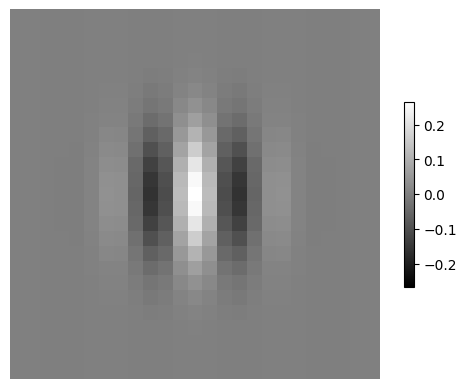

In [6]:
# The size of the Gaussian aperture in standard deviations
size = 3 #old:sigma.#higher value direc
frequency = 0.5 / size #Inversely proportional to envelope size.
orientation = 0. #Creates filter tuned to diagnoal or vertical edges.
phase_of_sinu = 0.#defines where the waves start  0<= phase_of_sinu<=pi/2
size_std = 4. #size of kernel matrix
gabor = np.real(
                skimage.filters.gabor_kernel(
                    frequency=frequency,
                    theta=orientation,
                    sigma_x=size,
                    sigma_y=size,
                    offset=phase_of_sinu,
                    n_stds=size_std,
                )
            )
# important to set unit length if you want to compare responses
# across filters with different sizes
gabor /= np.linalg.norm(gabor)
absmax = np.max(np.abs(gabor))

#visualize kernel using imshow()
fig, ax = plt.subplots(1, 1) #one figure(fig) and one subplot(ax)
ax.set_axis_off() #hides ticks so that we can focus on the image itself
im = ax.imshow(gabor, vmin=-absmax, vmax=absmax)
#im displays gabor filter as a 2D image.
#+ve and -ve wage regions are color-balanced, black for negative and white for positive and gray at zero.
fig.colorbar(im, shrink=.5)
#shrink=0.5 reduces height of colorbar to 50% of the axis height.

# **STEP 3**: Load and preprocess an Image

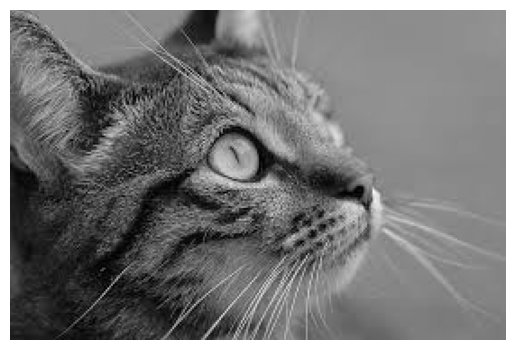

In [7]:
from skimage.io import imread
from skimage.color import rgb2gray

# Step 3: Load and preprocess grayscale image (replacing text image with a cat)

cat_raw = imread("cat1.jpeg")  # load cat image (ensure it's uploaded to runtime)
# Convert to grayscale if image is RGB
if cat_raw.ndim == 3:#RGB has 3 componenets
    cat_gray = rgb2gray(cat_raw)
else:
    cat_gray = cat_raw

cat_gray = cat_gray.astype(float)        # convert pixel values to float point(imp for precison math ops )
cat_gray /= cat_gray.max()              # normalize pixel values to range [0,1]

# Display the normalized image
fig, ax = plt.subplots(1, 1)
ax.imshow(cat_gray, cmap="gray")        # use grayscale for edge clarity
ax.set_axis_off() #removes tick labels for cleaner image display

# Reshape image to 4D [batch, height, width, channel] for TensorFlow
cat_input = cat_gray[None, :, :, None] #height and width are image dimentions,batch size=1(1 image), channels=1(grayscale)
#tensorflow expects input in this 4D format.
# Remove mean intensity to avoid global brightness bias (important for convolutional filtering)
cat_input -= cat_input.mean()


# **STEP 4**: Build Gabor Filter Bank

In [8]:
# Evenly spaced orientations(0 to pi)
orientations = gwp.n2orientations(8)
#creat gabor filter banks to model V1 simple cells.
# quadrature-offset filters
gabor_filter_bank = [gwp.gaborbank(sigma=size, orientations=orientations, nsigma=4, phase=this_phase)
                for this_phase in [0, np.pi/2]]
#To check shape of one phase's filter bank (height x width x orientations)
gabor_filter_bank[0].shape

(25, 25, 1, 8)

# **STEP 5**: V1 Energy for one orientation

Text(0.5, 1.0, 'energy')

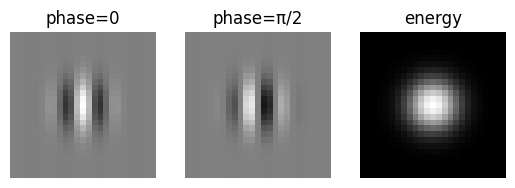

In [9]:
energy = gwp.v1energy(*gabor_filter_bank) #compute complex cell like energy from phase offset gabor filters
#create a subplot grid to visualize filters and energy maps
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True) #creates a single row of 3 subplots, sharey and sharex
#ensures that all subplots share the same axes scale.
[this_ax.set_axis_off() for this_ax in ax.ravel()] #removes axis ticks to keep images clean.

#compute maximum absolute filter values for consistent colormap scaling.
'''
we take abs() as gabor filters have both positive and negative wave regions.
Maximum value is taken to normalize colormap scale.
'''
bank_max = max(*[np.abs(thisbank).max() for thisbank in gabor_filter_bank])
#visualize phase 0 gabor filters for orientation 0
'''
Simple Cells are V1 neurons that respond to stimuli with particular orientations to objects within their receptive field.(Simple Cells, 2025)
These cells repond to very basic visual patterns
phase 0 filter bank(cosine wave), this filter behaves like a V1 simple cell that detects horizontal edges
at phase=0.
'''
ax[0].imshow(gabor_filter_bank[0][:,:,0,0], vmin=-bank_max, vmax=bank_max)
ax[0].set_title('phase=0')
#visualize phase pi/2 gabor filters for orientation 0
'''
phase pi/2 filter bank(sin wave), this filter behaves like a V1 simple cell that detects horizontal edges
at phase=pi/2.
'''
ax[1].imshow(gabor_filter_bank[1][:,:,0,0], vmin=-bank_max, vmax=bank_max)
ax[1].set_title('phase=π/2')
#visualize combined energy, combined response of the two phase-offset filters.
#This combined response simulates behavior of a complex cell
ax[2].imshow(energy[:,:,0,0])
ax[2].set_title('energy')

# **STEP 6**: Apply Gabor Bank to the Image

In [13]:
# convolve banks with stimulus to obtain raw responses
stride = 2 * size
responses = [gwp.convolver(cat_input, this_phase_bank, stride) for this_phase_bank in gabor_filter_bank]
# calculate V1 energy (sum of squares)
energy = gwp.v1energy(*responses)

[None, None, None, None, None, None, None, None]

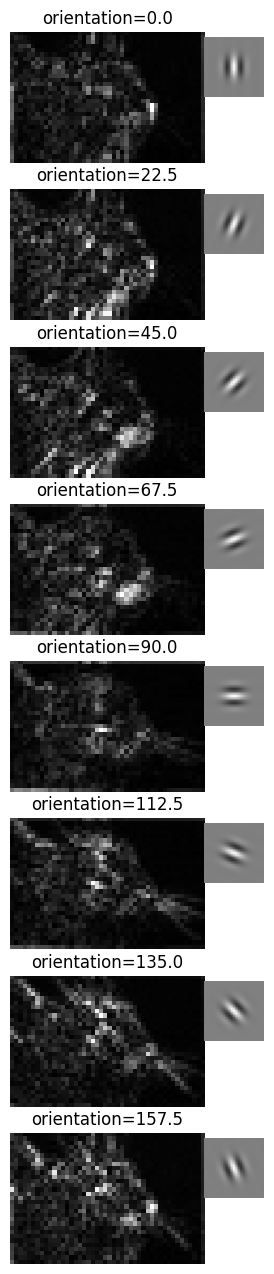

In [18]:
fig,ax = plt.subplots(len(orientations), 1, figsize=[5, 16])
#[this_ax.set_axis_off() for this_ax in ax.ravel()]
gabor_filter_ax = [] #to hold inset axes for displaying the filters
inset_size = (0.12, 0.12) #controls how small the embedded image is
n_col=1 #1 insert per row
for ind, energy_ax in enumerate(ax):
    energy_ax.imshow(energy[0,:,:,ind], vmin=0.) #diaplys V1 energy map for selected orientation.
    energy_ax.set_title(f"orientation={orientations[ind] * (180./np.pi)}")
    #compute inset position for gabor filter
    energy_ax_pos = energy_ax.get_position(original=False)
    # hack a multi-column representation since filters are often larger than response map
    inset_pos = [energy_ax_pos.x1 + (inset_size[0] * np.remainder(ind, n_col)),
                                       energy_ax_pos.y0, inset_size[0], inset_size[1]]
    #Show the Gabor filter (phase = 0) corresponding to this orientation
    #plots filter at phase 0 for orientation
    #bank_max keeps the color scale consistent across all filters.
    gabor_filter_ax.append(fig.add_axes(inset_pos))
    gabor_filter_ax[-1].imshow(gabor_filter_bank[0][:,:,0,ind], vmin=-bank_max, vmax=bank_max)
#Remove axis lines and ticks for clean presentation
[this_ax.set_axis_off() for this_ax in ax]
[this_ax.set_axis_off() for this_ax in gabor_filter_ax]


# **STEP 7**: Visualize Combined V1 (Summed Over Orientatins)

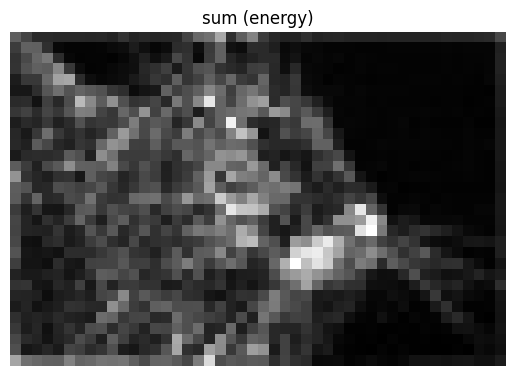

In [15]:
# just summing the orientation  (that is, equal weight on all orientations)
# to get one energy map, this will show where the image in the computational brain model detects any strong edge(Carlin, 2021).
fig, sum_all_ax = plt.subplots(1, 1)
sum_all_ax.imshow(np.sum(energy[0,:,:,:], axis=2)) #selects energy responses, gives 2D image.
sum_all_ax.set_title('sum (energy)')
sum_all_ax.set_axis_off()

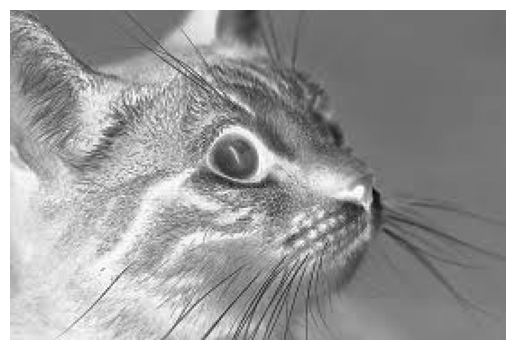

In [11]:
# reverse all local contrast relations
dc = cat_input.mean()
image_invert = cat_input * -1
fig, sum_all_ax = plt.subplots(1, 1)
sum_all_ax.imshow(dc + image_invert[0,:,:,0])
sum_all_ax.set_axis_off()

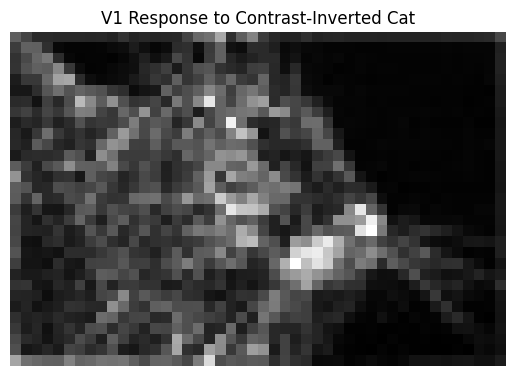

In [16]:
# Test V1 response to contrast-inverted cat image
# Invert the cat image (contrast) — still mean-centered
cat_input_invert = -1 * cat_input  # flipping polarity

# Apply Gabor filters to the inverted image
energy_invert = gwp.v1energy(*[
    gwp.convolver(cat_input_invert, this_phase_bank, stride)
    for this_phase_bank in gabor_filter_bank
])

#Visualize total energy summed across orientations
fig, ax = plt.subplots(1, 1)
ax.imshow(np.sum(energy_invert[0, :, :, :], axis=2), cmap='gray')
ax.set_title("V1 Response to Contrast-Inverted Cat")
ax.set_axis_off()


In [17]:
#check if V1 energy responses for original and contrast-inverted images are approximately equal.
np.allclose(energy, energy_invert)

True